# Create Individual Tools

For each site, create:
- read only view of the data and map
- editable view of the data and map(with updated template for unique numbers)
- dashboard of the sites stats

#### Import statments

In [28]:
import arcgis
gis = arcgis.gis.GIS(profile="ag")

# import modules
import json
import copy
import os
import string
import random
from getpass import getpass

from arcgis.geometry import Geometry
from arcgis.features import FeatureLayerCollection

#### Set output path

In [2]:
basePath = r'C:\Users\rjc.EAGLE\Documents\GitHub\agriculture-data-model'
outputFolders = os.listdir('{0}\\output'.format(basePath))

n = 0
for folder in outputFolders:
    print('{0} - {1}'.format(n, folder))
    n+=1
    
selectedFolder = int(input('Select a output folder: '))
outputPath = '{0}\\output\\{1}'.format(basePath, outputFolders[selectedFolder])
print('Output path: {0}'.format(outputPath))

0 - example-farm
1 - test


Select a output folder:  0


Output path: C:\Users\rjc.EAGLE\Documents\GitHub\agriculture-data-model\output\example-farm


#### Load in Data Model

In [3]:
data = {}
try:    
    data.update(json.load(open('{0}\\service\\{1}.json'.format(outputPath, 'datamodel'))))
except Exception as e:
    print (e)

#### Define the versions that will be created

In [4]:
versions = [
    {'name':'Stakeholder', 'title':'stakeholder', 'capabilities': 'Query,Sync'},            
    {'name':'Fieldworker', 'title':'fieldworker', 'capabilities': 'Create,Delete,Query,Update,Sync,ChangeTracking'}
]

#### Get all sites groups and all sites folders

In [6]:
allSites = {}

folders = gis.users.me.folders
folderDetails = [x for x in folders if x['title'] == 'All Sites Data'][0]
allSites['folder'] = {}
allSites['folder']['title'] = folderDetails['title']
allSites['folder']['id'] = folderDetails['id']

allSites['fieldworker'] = gis.groups.get('21ae7bbee311458fbc135f73a414cc4e') #input('Fieldworker Group ID: ')
allSites['stakeholder'] = gis.groups.get('ed6cf227059444db973e611daf9fdb3f')

#### Get list of all sites

In [7]:
administrativeInformationItemID = data['services'][0]['id']
administrativeInformation = gis.content.get(administrativeInformationItemID)
sites = administrativeInformation.layers[2].query().features
siteCatalog = {}

#### Create a group for each site

In [8]:
for site in sites:   
    
    uniqueNumber = site.attributes['unique_number']
    siteCatalog[uniqueNumber] = {}
    for version in versions:  
        
        groupName = "Site {0} ({1})".format(uniqueNumber, version['name'])
        groupDescription = "A group for sharing content relating to site {0} for {1} use".format(uniqueNumber, version['name'])
        
        # return a list of the existing groups
        existingGroups = gis.groups.search(groupName)
        if existingGroups != []:
            if existingGroups[0].title == groupName:
                group = existingGroups[0]
        else:    
            group = gis.groups.create(groupName, uniqueNumber, groupDescription)  
        
        # update site catalog
        siteCatalog[uniqueNumber][version['title']] = {}
        siteCatalog[uniqueNumber][version['title']]['groupName'] = groupName
        siteCatalog[uniqueNumber][version['title']]['groupId'] = group.id
        siteCatalog[uniqueNumber][version['title']]['views'] = {}

#### Create a view for each service and site

In [9]:
for service in data['services']:
    
    print(service['name'])
    item = gis.content.get(service['id'])
    featureLayerCollection = FeatureLayerCollection.fromitem(item)   
    
    for site in sites:
        
        uniqueNumber = site.attributes['unique_number']
        print('    - {0}'.format(uniqueNumber))
        siteQuery = administrativeInformation.layers[2].query("unique_number = {0}".format(uniqueNumber), out_sr=4326).features[0]
        extent = Geometry(siteQuery.geometry).extent
        
        for version in versions:
            
            print('        - {0}'.format(version['title']))            
            viewTitle = '{0}_{1}_{2}_view'.format(service['name'], uniqueNumber, version['title'])
            viewName = '{0} {1} - {2} View'.format(service['alias'], uniqueNumber, version['name'])
            
            #if service['name'] not in siteCatalog[uniqueNumber][version['title']]['views'].keys():

            existingViews = gis.content.search(viewTitle)
            if existingViews != []:
                existingViewNames = [x.name for x in existingViews]
                if viewTitle in existingViewNames:
                    view = existingViews[existingViewNames.index(viewTitle)]
                    print('            + view already exists')
                else:
                    view = featureLayerCollection.manager.create_view(viewTitle, extent=extent, capabilities=version['capabilities'])
                    print('            + view created')
            else:
                view = featureLayerCollection.manager.create_view(viewTitle, extent=extent, capabilities=version['capabilities'])  
                print('            + view created') 

            if view.ownerFolder != allSites['folder']['id']:
                view.move(folder=allSites['folder']['title'])
                print('            + moved to {0}'.format(allSites['folder']['title'].lower()))
            else:
                print('            + already in {0}'.format(allSites['folder']['title'].lower())) 

            groupID = siteCatalog[uniqueNumber][version['title']]['groupId']
            group = gis.groups.get(groupID)
            sharedWith = [x.title for x in view.shared_with['groups']]
            if group.title not in sharedWith:
                view.share(groups=[group]) 
                print('            + shared to {0}'.format(group.title.lower())) 
            else:
                print('            + already shared to {0}'.format(group.title.lower())) 
                
            if allSites[version['title']].title not in sharedWith:
                view.share(groups=[allSites[version['title']]])
                print('            + shared to {0}'.format(allSites[version['title']].title.lower())) 
            else:
                print('            + already shared to {0}'.format(allSites[version['title']].title.lower())) 

            viewItemProperties = {
                'snippet': '{0} view for site {1} ({2})'.format(version['name'], uniqueNumber, service['alias']),
                'tags': '{0},{1}'.format(uniqueNumber, version['title']), 
                'title': '{0}'.format(viewName)
            }                    
            view.update(viewItemProperties) # thumbnail='/arcgis/home/FarmDataMaster.png'
            print('            + item properties updated') 

            for layer in view.layers:

                layerProperties = layer.properties
                if 'definitionQuery' in layerProperties.keys():
                    del layerProperties['definitionQuery']

                definitionStatement = 'unique_number = {0}'.format(uniqueNumber)
                definitionQuery = {'viewDefinitionQuery': definitionStatement} 
                fieldNames = [x['name'] for x in layerProperties['fields']]

                if 'viewDefinitionQuery' in layerProperties:
                    if layerProperties['viewDefinitionQuery'] != definitionStatement and 'unique_number' in fieldNames:                            
                        layer.manager.update_definition(definitionQuery)
                        print('                * {0} definition query updated'.format(layerProperties['name'].lower()))
                    else:
                        print('                * {0} definition query already updated'.format(layerProperties['name'].lower()))  
                else:
                    layer.manager.update_definition(definitionQuery)
                    print('                * {0} definition query updated'.format(layerProperties['name'].lower()))  

                if version['title'] == 'fieldworker':
                    layerTemplates = layerProperties['templates']
                    for template in layerTemplates:
                        
                        if 'unique_number' in template['prototype']['attributes'].keys():
                            if template['prototype']['attributes']['unique_number'] != uniqueNumber:
                                template['prototype']['attributes']['unique_number'] = uniqueNumber

                                layerProperties['editingInfo']['lastEditDate'] = ''
                                layer.manager.update_definition(layerProperties)
                                print('                * {0} template updated'.format(layerProperties['name'].lower())) 
                            
                            else:
                                print('                * {0} template already updated'.format(layerProperties['name'].lower())) 
                        else:
                            print('                * {0} has no field unique_number'.format(layerProperties['name'].lower())) 
                            

            siteCatalog[uniqueNumber][version['title']]['views'][service['name']] = view.id    
           
            
    print(' ')

administrative_information
    - 4391
        - stakeholder
            + view already exists
            + already in all sites data
            + already shared to site 4391 (stakeholder)
            + already shared to all sites (stakeholder)
            + item properties updated
                * access points definition query already updated
                * blocks definition query already updated
                * site definition query already updated
                * holding definition query already updated
        - fieldworker
            + view already exists
            + already in all sites data
            + already shared to site 4391 (fieldworker)
            + already shared to all sites (fieldworker)
            + item properties updated
                * access points definition query already updated
                * access points template already updated
                * blocks definition query already updated
                * blocks template already updated
  

#### Create a map for each site and version

In [94]:
mapTemplate = gis.content.get('669c08af54594e7b80f2042744b2b468')

for site in sites:

    uniqueNumber = site.attributes['unique_number']
    print('{0}'.format(uniqueNumber))
    siteQueryWGS = administrativeInformation.layers[2].query("unique_number = {0}".format(uniqueNumber), out_sr=4326).features[0]
    extentWGS = Geometry(siteQueryWGS.geometry).extent
    siteQueryNZTM = administrativeInformation.layers[2].query("unique_number = {0}".format(uniqueNumber), out_sr=2193).features[0]
    extentNZTM = Geometry(siteQueryNZTM.geometry).extent

    for version in versions:
        
        mapName = 'Site {1} - {2} Map'.format(service['alias'], uniqueNumber, version['name'])        
        
        
        ### create
        existingMaps = gis.content.search(mapName)
        check = [x for x in existingMaps if mapName in x.title]
        if check == []:
            newMap = mapTemplate.copy(title=mapName, tags='{0},{1},IndividualFarm'.format(uniqueNumber,version['title']))
            print('    - Created {0}'.format(mapName))
            
        else:
            newMap = check[0]
            print('    - {0} already exists'.format(mapName))
            
        
        ### folder
        if newMap.ownerFolder != allSites['folder']['id']:
            newMap.move(folder=allSites['folder']['title'])
            print('            + moved to {0}'.format(allSites['folder']['title'].lower()))
        else:
            print('            + already in {0}'.format(allSites['folder']['title'].lower())) 
        
        
        ### group
        groupID = siteCatalog[uniqueNumber][version['title']]['groupId']
        group = gis.groups.get(groupID)
        
        sharedWith = [x.title for x in newMap.shared_with['groups']]
        if group.title not in sharedWith:
            newMap.share(groups=[group]) 
            print('            + shared to {0}'.format(group.title.lower())) 
        else:
            print('            + already shared to {0}'.format(group.title.lower())) 
        
        
        ### properties extent
        propertiesExtent = ','.join([str(x) for x in extentWGS])
        newMap.update({'extent': propertiesExtent})
        print('            + extent updated')   
        
        ### item data
        
        itemData = newMap.get_data()
        
        mapExtent = {}
        mapExtent['spatialReference'] = {'latestWkid': 2193, 'wkid': 2193}
        mapExtent['xmin'] = extentNZTM[0]
        mapExtent['ymin'] = extentNZTM[1]
        mapExtent['xmax'] = extentNZTM[2]
        mapExtent['ymax'] = extentNZTM[3]
        
        itemData['initialState']['viewpoint']['targetGeometry'] = mapExtent
        
        n = 1
        characters = string.ascii_lowercase + string.digits
        
        itemData['operationalLayers'] = []
        
        groupContent = group.content()
        groupLayers = [x for x in groupContent if x.type == 'Feature Service']    
        
        for content in groupLayers:

            groupLayer = {}
            groupLayer['id'] = '{0}-layer-{1}'.format(''.join(random.choice(characters) for i in range(11)),n)
            groupLayer['title'] = content.title
            groupLayer['layerType'] = 'GroupLayer'
            groupLayer['layers'] = []
            n+=1

            for layer in content.layers:

                layerProperties = layer.properties

                layerDetails = {}
                layerDetails['id'] = '{0}-layer-{1}'.format(''.join(random.choice(characters) for i in range(11)),n)
                layerDetails['title'] = layerProperties['name']
                layerDetails['url'] = layer.url
                layerDetails['itemId'] = layerProperties['serviceItemId']
                layerDetails['layerType'] = 'ArcGISFeatureLayer'
                groupLayer['layers'].append(layerDetails)  
                n+=1

            itemData['operationalLayers'].append(groupLayer)
        
        newMap.update(data=itemData)

4391
    - Site 4391 - Stakeholder Map already exists
            + already in all sites data
            + already shared to site 4391 (stakeholder)
            + extent updated
    - Site 4391 - Fieldworker Map already exists
            + already in all sites data
            + already shared to site 4391 (fieldworker)
            + extent updated
3671
    - Site 3671 - Stakeholder Map already exists
            + already in all sites data
            + already shared to site 3671 (stakeholder)
            + extent updated
    - Site 3671 - Fieldworker Map already exists
            + already in all sites data
            + already shared to site 3671 (fieldworker)
            + extent updated


<Item title:"Site 3671 - Fieldworker Map" type:Web Map owner:ag_svcs>
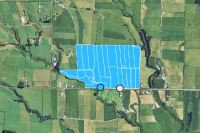

In [95]:
newMap

In [19]:
[x['id'] for x in itemData['operationalLayers'][0]['layers']]

['17e9e3c43df-layer-2',
 '17e9e3c43e0-layer-3',
 '17e9e3c43e0-layer-4',
 '17e9e3c43e1-layer-5']

In [20]:
[x['id'] for x in itemData['tables']]

['17e9e3c43e2-layer-6',
 '17e9e3c43e3-layer-7',
 '17e9e3c43e4-layer-8',
 '17e9e3c43e5-layer-9']

In [34]:
characters = string.ascii_lowercase + string.digits
layerId = ''.join(random.choice(characters) for i in range(11))
layerId

'tl7c8cnlzde'

In [53]:
testMap = gis.content.get('258b01efbac2423b92fb7845a755da9f')
testData = testMap.get_data()
testOperationalLayers = testData['operationalLayers']


In [54]:
itemData['operationalLayers'][0].keys()

dict_keys(['title', 'layerType', 'layers'])

In [56]:
itemData['operationalLayers'][0]['layers']

[{'id': 's6pt0exxc4d-layer-1',
  'title': 'Point Activities',
  'url': 'https://services.arcgis.com/hMYNkrKaydBeWRXE/arcgis/rest/services/activities_3671_fieldworker_view/FeatureServer/0',
  'itemId': '62c947030c354a23b827ad6c1e672160',
  'layerType': 'Feature Layer'},
 {'id': 'm9mfgdr3p12-layer-2',
  'title': 'Line Activities',
  'url': 'https://services.arcgis.com/hMYNkrKaydBeWRXE/arcgis/rest/services/activities_3671_fieldworker_view/FeatureServer/1',
  'itemId': '62c947030c354a23b827ad6c1e672160',
  'layerType': 'Feature Layer'},
 {'id': 'qjdzajoz7p3-layer-3',
  'title': 'Polygon Activities',
  'url': 'https://services.arcgis.com/hMYNkrKaydBeWRXE/arcgis/rest/services/activities_3671_fieldworker_view/FeatureServer/2',
  'itemId': '62c947030c354a23b827ad6c1e672160',
  'layerType': 'Feature Layer'}]

In [11]:
itemData['operationalLayers'][0]['layers'][0].keys()

dict_keys(['id', 'title', 'url', 'itemId', 'layerType', 'popupInfo'])

In [ ]:
newMap

In [ ]:
itemData['operationalLayers'][0]['layers'][2]

In [ ]:
itemData['operationalLayers'][0]['title']

In [42]:
itemData['operationalLayers'][0]['layers'][0].keys()

dict_keys(['id', 'title', 'url', 'itemId', 'layerType', 'popupInfo'])

In [57]:
layerProperties['type']

'Feature Layer'

In [92]:
itemData

{'operationalLayers': [{'id': 'c7tw5j8svik-layer-1',
   'title': 'Activities 3671 - Fieldworker View',
   'layerType': 'GroupLayer',
   'layers': [{'id': 'e96sl4iftq4-layer-2',
     'title': 'Point Activities',
     'url': 'https://services.arcgis.com/hMYNkrKaydBeWRXE/arcgis/rest/services/activities_3671_fieldworker_view/FeatureServer/0',
     'itemId': '62c947030c354a23b827ad6c1e672160',
     'layerType': 'ArcGISFeatureLayer'},
    {'id': 'xfsxzsbinzs-layer-3',
     'title': 'Line Activities',
     'url': 'https://services.arcgis.com/hMYNkrKaydBeWRXE/arcgis/rest/services/activities_3671_fieldworker_view/FeatureServer/1',
     'itemId': '62c947030c354a23b827ad6c1e672160',
     'layerType': 'ArcGISFeatureLayer'},
    {'id': '6dberj74bgq-layer-4',
     'title': 'Polygon Activities',
     'url': 'https://services.arcgis.com/hMYNkrKaydBeWRXE/arcgis/rest/services/activities_3671_fieldworker_view/FeatureServer/2',
     'itemId': '62c947030c354a23b827ad6c1e672160',
     'layerType': 'ArcGISFe

<Item title:"Site 3671 - Fieldworker Map" type:Web Map owner:ag_svcs>
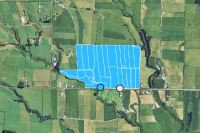

In [93]:
newMap.update(data=itemData)
newMap

In [85]:
itemData['operationalLayers'] = []

n = 1
characters = string.ascii_lowercase + string.digits
groupLayers = [x for x in groupContent if x.type == 'Feature Service']
for content in groupLayers:
    
    for layer in content.layers:
        
        layerProperties = layer.properties
        
        layerDetails = {}
        layerDetails['id'] = '{0}-layer-{1}'.format(''.join(random.choice(characters) for i in range(11)),n)
        layerDetails['title'] = layerProperties['name']
        layerDetails['url'] = layer.url
        layerDetails['itemId'] = layerProperties['serviceItemId']
        layerDetails['layerType'] = layerProperties['type']
        groupLayer['layers'].append(layerDetails)  
        n+=1
        
        itemData['operationalLayers'].append(layerDetails)

In [78]:
layer

<FeatureLayer url:"https://services.arcgis.com/hMYNkrKaydBeWRXE/arcgis/rest/services/water_utilities_3671_fieldworker_view/FeatureServer/3">

In [80]:
from arcgis.mapping import WebMap


In [82]:
wmItem = WebMap(newMap)
wmItem

MapView(hide_mode_switch=True, layout=Layout(height='400px', width='100%'))

In [87]:
wmItem.update()

True

In [83]:
wmItem.add_layer(layer)

True

In [86]:
wmItem.update(data=itemData)

TypeError: update() got an unexpected keyword argument 'data'

In [ ]:
testMap = gis.content.get('2ddb1eb1b1094ef989d9838db0beb917')

In [ ]:
x = testMap.get_data()

In [ ]:
x['operationalLayers'][0]

In [ ]:
itemData['operationalLayers'][0]